# Lecture Course on "Computational Quantum Dynamics"

__This project has been carried out by:__ Mathieu Kaltschmidt and Carl von Randow

# The Gross-Pitaevskii equation (GPE): Dynamics of solitons and vortices

The GPE is a mean field equation that has been incredibly successful in describing the dynamics of Bose Einstein condensates (BECs). The equation features a non-linear term and thus allows for stable soliton solutions in 1D and additional topological defects such as vortices in 2D. The goal of this project is to study these phenomena using the split-step Fourier method.

We sometimes had problems with the animations (AttributeError: 'NoneType' object has no attribute 'remove_callback') and were not able to find a good solution, but after running the whole notebook again it somehow worked. We hope you won't encounter the same problems.

In [60]:
#Importing packages and some basic settings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib import animation
from mpl_toolkits import mplot3d

#Fast Fourier transforms
from numpy.fft import fft, ifft, fftshift, fftfreq

#Some plot setings
import matplotlib as mpl
mpl.rcParams['legend.handlelength'] = 0.5
pgf_with_rc_fonts = {
    "font.family": "serif",
    "font.serif": [],                   # use latex default serif font
    "font.sans-serif": ["Deja Vu Sans"], # use a specific sans-serif font
}
mpl.rcParams.update(pgf_with_rc_fonts)

Mymarkersize = 3.5
myfontsize = 3

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman'], 'size':myfontsize})
rc('text', usetex=True)
rc('legend', fontsize=3.0)

#Other useful packages
import sys
import h5py as h
import scipy.special as special
import scipy.ndimage as ndimage
from scipy.optimize import curve_fit, newton
from scipy.interpolate import interp1d
import scipy.optimize as optimization
import timeit

plt.style.use('seaborn-talk')

## 1) The evolution of dark solitons in a homogeneous 1D Bose gas

### Numerical solution

In [21]:
#Some basic parameters of our setting
hbar = 1
g = 1
m, n = 1, 1
xi = 1/np.sqrt(m*n*g) #healing length
rho = 1./(g*xi**2) #background density
c_s = np.sqrt(rho*g/m) #speed of sound

print("Homogeneous background density:" , rho)

#defining spatial grid structure
L = 240
N_grid = 2048
dx = L/N_grid
grid = np.linspace(-L/2, L/2, N_grid, endpoint = False)
k_grid = 2*np.pi * np.fft.fftfreq(N_grid, d = dx)

N = rho * N_grid
print("Particle number: " , N)

#time settings
dt = 0.01
tsteps = 800

Homogeneous background density: 1.0
Particle number:  2048.0


In [31]:
#Initializing a single soliton with greyness nu at z0
def InitSoliton(z, z0, nu):
    gamma = 1/np.sqrt(1-nu**2)
    return np.sqrt(rho) * (1j*nu + gamma**(-1) * np.tanh((z - z0)/(np.sqrt(2)*xi*gamma)))

#some different initial conditions
sol_black = InitSoliton(grid, 0, 0)
sol_grey_0 = InitSoliton(grid, 0, 0.8)
sol_grey_1 = InitSoliton(grid, -3, 0.8)
sol_grey_2 = InitSoliton(grid, 3, -0.8)

#### Implementing the split-step Fourier method

In [23]:
kinetic_evolution = np.exp(-1j  * (k_grid**2) * dt / 2)

def single_step(psi, kinetic_evolution, g = 1, dt = 0.01):
    # go to Fourier space
    psi = np.fft.fftn(psi)
    # apply kinetic part
    psi = kinetic_evolution * psi
    # go back to real space
    psi = np.fft.ifftn(psi)
    psi = np.exp(-1j * dt * g * np.abs(psi)**2) * psi
    return psi

def full_split_step_method(psi, kinetic_evolution, g = 1, dt = 0.01, tsteps = 800):
    time_evolution = np.zeros((tsteps + 1, *np.shape(psi)), dtype = np.complex128)
    time_evolution[0] = psi
    
    for i in range(tsteps+1)[1:]:
        psi = single_step(psi, kinetic_evolution, g, dt)
        time_evolution[i] = psi
    
    return time_evolution

#### One single black Soliton

<IPython.core.display.Javascript object>


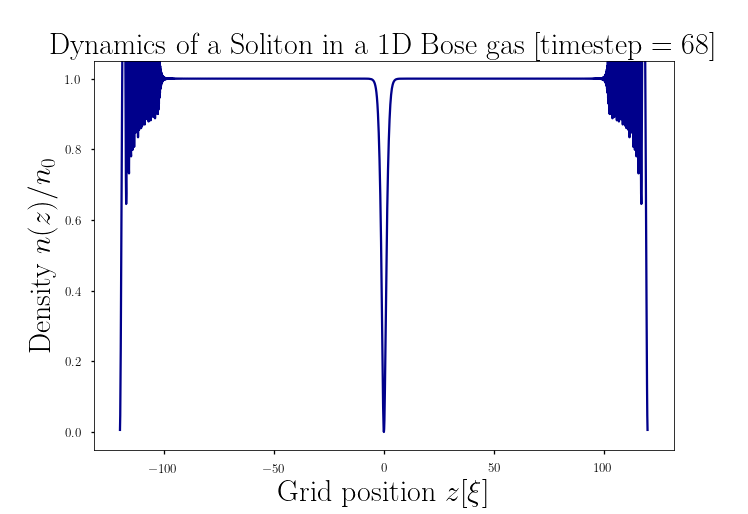

In [32]:
#axes specifications
fig, axes = plt.subplots(1,1)
axes.set_xlabel(r"Grid position $z[\xi]$", size = 30)
axes.set_ylabel(r"Density $n(z)/n_0$", size = 30)

time_evol = full_split_step_method(sol_black, kinetic_evolution, g = 1, dt = 0.01, tsteps = 800)

line, = (axes.plot(grid/xi, np.abs(time_evol[0])**2, color='darkblue'))

axes.set_title(r"Dynamics of a Soliton in a 1D Bose gas [timestep $= {}$]".format(str(round(0,2))), size = 30)

def animate(t):
    # assign current wave function to y
    axes.set_title(r"Dynamics of a Soliton in a 1D Bose gas [timestep $= {}$]".format(str(round(t,2))), size = 30)
    line.set_data(grid/xi , np.abs(time_evol[t])**2)
    
anim = animation.FuncAnimation(fig, animate,
                               frames=np.arange(0,tsteps,4), # t-values and steps
                               interval=100, # wait time before displaying new frame in ms
                               blit=True)
plt.show()

#### One single grey Soliton

<IPython.core.display.Javascript object>


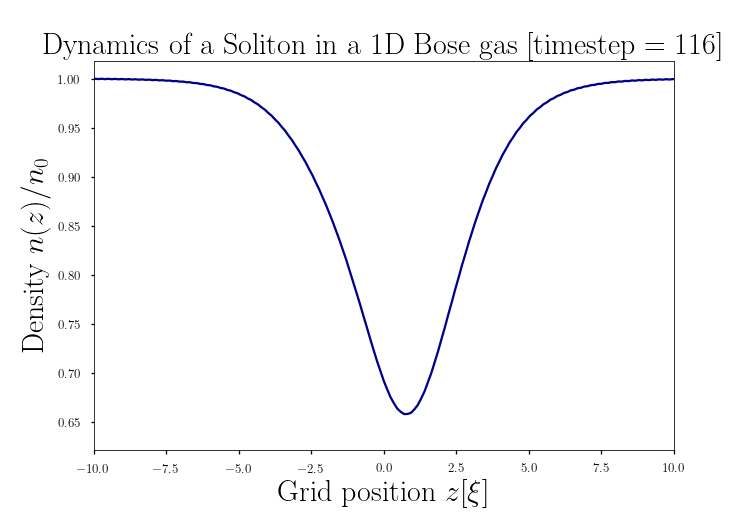

In [33]:
#axes specifications
fig, axes = plt.subplots(1,1)
axes.set_xlabel(r"Grid position $z[\xi]$", size = 30)
axes.set_ylabel(r"Density $n(z)/n_0$", size = 30)

time_evol = full_split_step_method(sol_grey_0, kinetic_evolution, g = 1, dt = 0.01, tsteps = 800)

line, = (axes.plot(grid/xi, np.abs(time_evol[0])**2, color='darkblue'))

axes.set_title(r"Dynamics of a Soliton in a 1D Bose gas [timestep $= {}$]".format(str(round(0,2))), size = 30)
axes.set_xlim(-10, 10)

def animate(t):
    # assign current wave function to y
    axes.set_title(r"Dynamics of a Soliton in a 1D Bose gas [timestep $= {}$]".format(str(round(t,2))), size = 30)
    line.set_data(grid/xi , np.abs(time_evol[t])**2)
    axes.set_xlim(-10, 10)
    
anim = animation.FuncAnimation(fig, animate,
                               frames=np.arange(0,tsteps,4), # t-values and steps
                               interval=100, # wait time before displaying new frame in ms
                               blit=True)
plt.show()

#### Superpostion of two grey Soltions

<IPython.core.display.Javascript object>


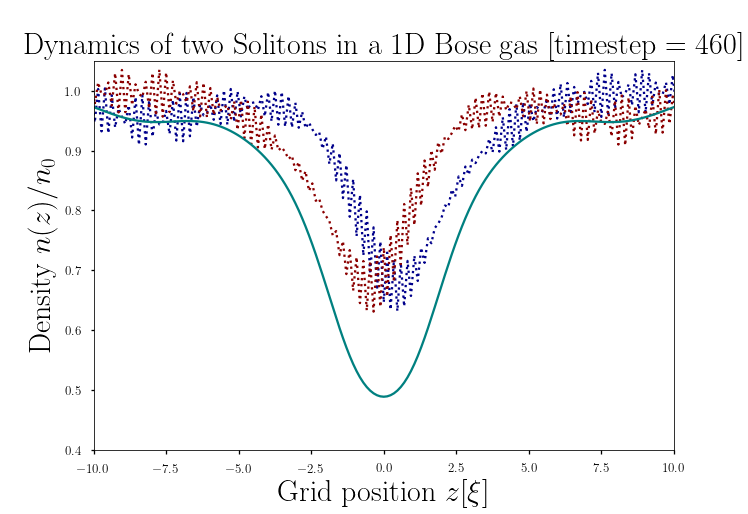

In [49]:
#axes specifications
fig, axes = plt.subplots(1,1)
axes.set_xlabel(r"Grid position $z[\xi]$", size = 30)
axes.set_ylabel(r"Density $n(z)/n_0$", size = 30)

time_evol = full_split_step_method(sol_grey_1 * sol_grey_2, kinetic_evolution, g = 1, dt = 0.01, tsteps = 800)
time_evol1 = full_split_step_method(sol_grey_1, kinetic_evolution, g = 1, dt = 0.01, tsteps = 800)
time_evol2 = full_split_step_method(sol_grey_2, kinetic_evolution, g = 1, dt = 0.01, tsteps = 800)

line1, = (axes.plot(grid/xi, np.abs(time_evol1[0])**2, color='darkblue', ls = ':', label = 'Grey Soliton #1'))
line2, = (axes.plot(grid/xi, np.abs(time_evol2[0])**2, color='darkred', ls = ':', label = 'Grey Soliton #1'))
line, = (axes.plot(grid/xi, np.abs(time_evol[0])**2, color='teal', label = 'Superposition'))

axes.set_xlim(-10, 10)
axes.set_ylim(0.4, 1.05)
#axes.legend(fontsize = 20, borderpad = .5, borderaxespad = .5, loc = 4)
axes.set_title(r"Dynamics of two Solitons in a 1D Bose gas [timestep $= {}$]".format(str(round(0,2))), size = 30)

def animate(t):
    # assign current wave function to y
    axes.set_title(r"Dynamics of two Solitons in a 1D Bose gas [timestep $= {}$]".format(str(round(t,2))), size = 30)
    line.set_data(grid/xi , np.abs(time_evol[t])**2)
    line1.set_data(grid/xi , np.abs(time_evol1[t])**2)
    line2.set_data(grid/xi , np.abs(time_evol2[t])**2)
    #axes.legend(fontsize = 20, borderpad = .5, borderaxespad = .5, loc = 4)


anim = animation.FuncAnimation(fig, animate,
                               frames=np.arange(0,tsteps,4), # t-values and steps
                               interval=100, # wait time before displaying new frame in ms
                               blit=True)
plt.show()

### Analytical solution

In [52]:
#analytical solution from paper as comparison
def analytical_1D(z, t, z0, nu = 0):
    gamma = 1 / np.sqrt(1 - nu ** 2)
    return np.sqrt(rho) * (1j*nu + gamma**(-1)*np.tanh((z - (z0+nu*c_s*t))/(np.sqrt(2)*xi*gamma)))*np.exp(1j*mu*t)

<IPython.core.display.Javascript object>


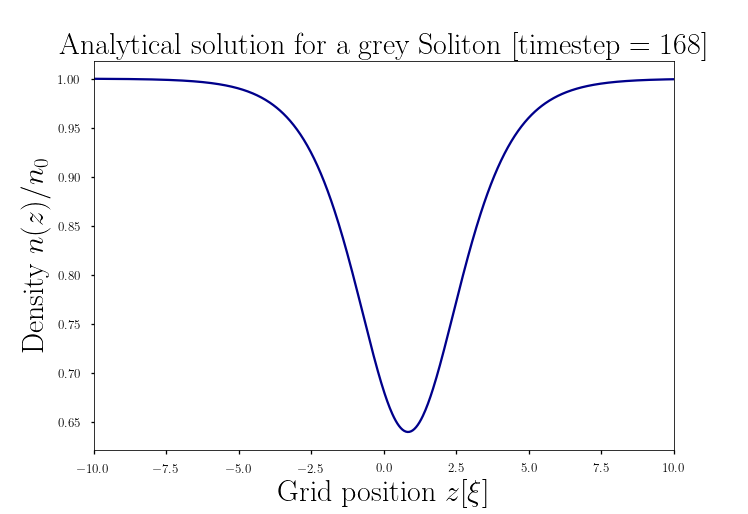

In [64]:
#axes specifications
fig, axes = plt.subplots(1,1)
axes.set_xlabel(r"Grid position $z[\xi]$", size = 30)
axes.set_ylabel(r"Density $n(z)/n_0$", size = 30)

time_range = np.linspace(0, 10, 400)
time_evol = [analytical_1D(grid, t = 0, z0 = 0, nu = 0.8)]
for t in time_range:
    time_evol.append(analytical_1D(grid, t, z0 = 0, nu = 0.8))

line, = (axes.plot(grid/xi, np.abs(time_evol[0])**2, color='darkblue'))

axes.set_title(r"Analytical solution for a grey Soliton [timestep $= {}$]".format(str(round(0,2))), size = 30)
axes.set_xlim(-10, 10)

def animate(t):
    # assign current wave function to y
    axes.set_title(r"Analytical solution for a grey Soliton [timestep $= {}$]".format(str(round(t,2))), size = 30)
    line.set_data(grid/xi , np.abs(time_evol[t])**2)
    axes.set_xlim(-10, 10)
    return line,
    
anim = animation.FuncAnimation(fig, animate,
                               frames=np.arange(0,400,4), # t-values and steps
                               interval=100, # wait time before displaying new frame in ms
                               blit=True)
plt.show()

## 2) Dynamics of solitons in a homogeneous 2D Bose gas

In this part of the project we want to add some perturbations to our (now 2D) homogeneous background density and check how the dynamics of the system is affected.

In [98]:
#create a grid with homogeneous condensate background density
def create_condensed_grid(nx_grid, ny_grid, N, meshgrid = False):
    grid = np.zeros((nx_grid,ny_grid), 'complex') #initialize grid in Fourier space
    grid[0,0] = np.sqrt(N/2.) + 1j*np.sqrt(N/2.) #fill condensate mode k=0 with all particles
    grid = np.fft.fft2(grid)/np.sqrt(nx_grid*ny_grid) #Fourier transform
    if meshgrid:
        return [*np.meshgrid(np.arange(nx_grid), np.arange(ny_grid)), grid]
    else:
        return grid

#calculate the total number of particles on the grid
def calculate_particle_number(grid):
    return np.sum(np.sum(np.abs(grid)**2, axis=0), axis=0)

In [99]:
#Initializing the 2D scenario
N_grid_x = 64
N_grid_y = 64
N = N_grid_x * N_grid_y
print("Particle number: " , N)
dx = 1

x, y, z = create_condensed_grid(N_grid_x, N_grid_y, N, meshgrid = True)
grid_2D = create_condensed_grid(N_grid_x, N_grid_y, N)

# spectral space
kx_ = 2*np.pi * np.fft.fftfreq(N_grid_x, d = dx)
ky_ = 2*np.pi * np.fft.fftfreq(N_grid_y, d = dx)
kx, ky = np.meshgrid(kx_, ky_)

Particle number:  4096


<IPython.core.display.Javascript object>


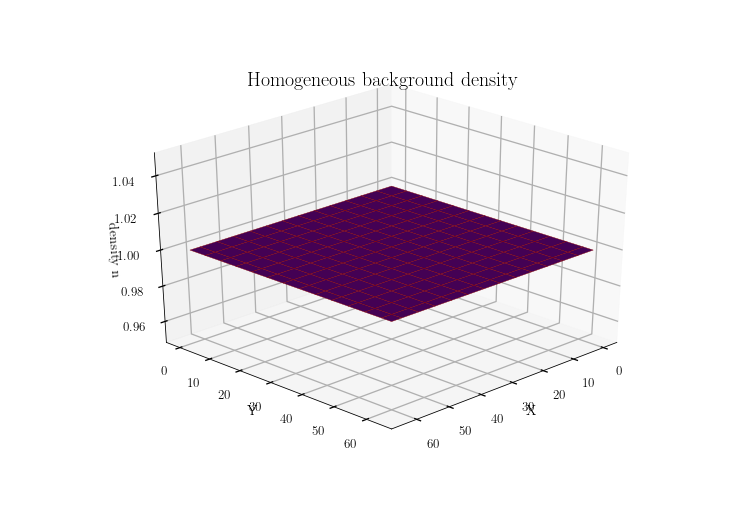

In [102]:
#Visualizing the density profile
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, np.abs(z)**2, rstride=5, cstride=5, cmap='viridis', edgecolor='darkred')
ax.set_title('Homogeneous background density', size = 20)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel(r'density n')
ax.view_init(30, 45)
#plt.imshow(grid2D.real)

#### Randomized noise

<IPython.core.display.Javascript object>


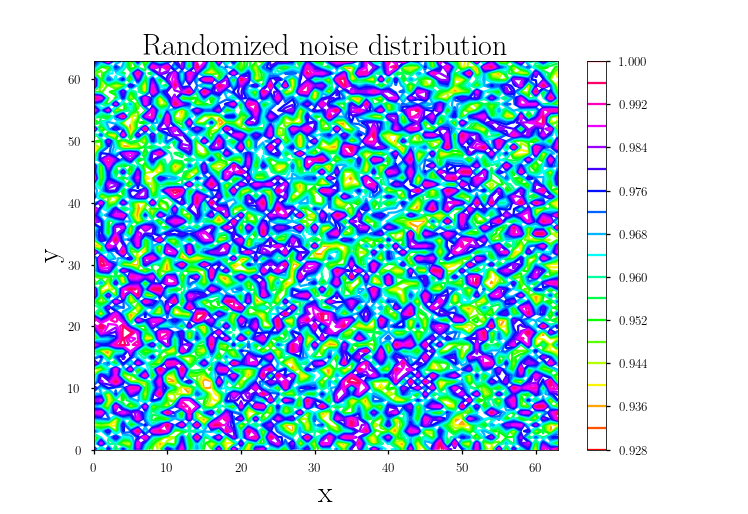

In [137]:
#adding some noise
init2D =  create_condensed_grid(N_grid_x, N_grid_y, N)
init2D -=  0.05 * np.random.random(np.shape(init2D))

#Visualizing the density profile
plt.contour(np.abs(init2D)**2, 20, cmap='hsv')
plt.colorbar()
plt.title('Randomized noise distribution', size = 30)
plt.xlabel('x', size = 30)
plt.ylabel('y', size = 30)
plt.savefig('random_noise.png', format = 'png')

In [138]:
dt = 0.01
tsteps = 100
kinetic_evolution = np.exp(-1j  * (kx**2 + ky**2) * dt / 2)

noise_evol = full_split_step_method(init2D, kinetic_evolution, g = 1, dt = 0.01, tsteps = 100)

<IPython.core.display.Javascript object>


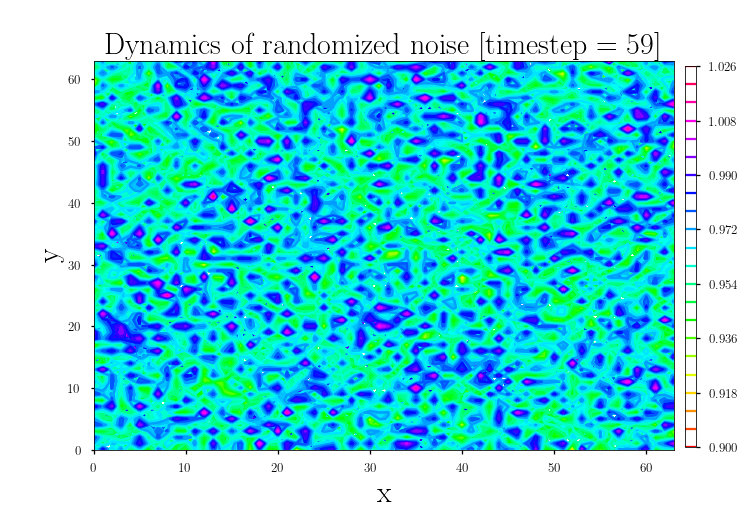

In [140]:
def update_contour_plot(t):
    im = ax.contour(np.abs(noise_evol[t])**2, 20, cmap = "hsv")
    fig.delaxes(plt.gca())
    cax = fig.add_axes([0.915, 0.13, 0.015, 0.74])
    fig.colorbar(im, cax = cax, ax = ax)
    ax.set_title(r"Dynamics of randomized noise [timestep $= {}$]".format(str(round(t,2))), size = 30)
    return im,

fig = plt.figure()
im = plt.contour(np.abs(init2D)**2, 20, cmap = 'hsv')
ax = fig.gca()
ax.set_title(r"Dynamics of randomized noise [timestep $= {}$]".format(str(round(0,2))), size = 30)
plt.xlabel('x', size = 30)
plt.ylabel('y', size = 30)
cax = fig.add_axes([0.915, 0.13, 0.015, 0.74])
fig.colorbar(im, cax = cax, ax = ax)

anim = animation.FuncAnimation(fig, update_contour_plot,
                               frames=np.arange(0,tsteps,1), # t-values and steps
                               interval=100, # wait time before displaying new frame in ms
                               blit = True)
plt.show()

#### Sinusoidal noise

<IPython.core.display.Javascript object>


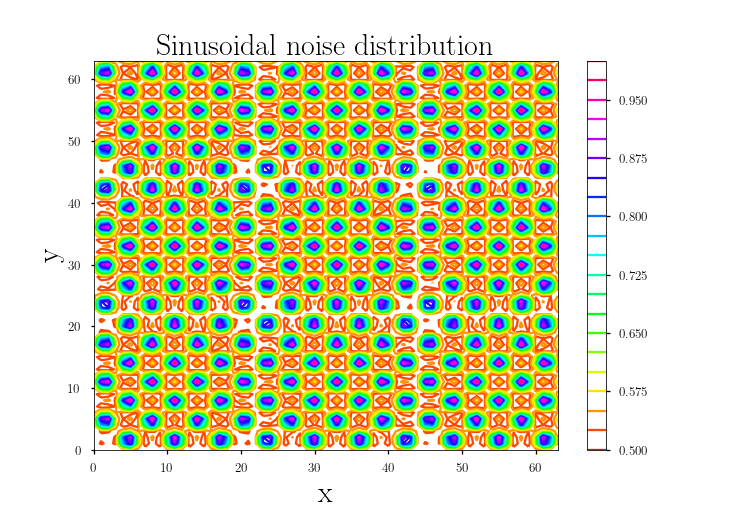

In [168]:
def sinus(x, y):
    return np.sin(x) * np.sin(y)

#adding some noise
init2D_sin =  create_condensed_grid(N_grid_x, N_grid_y, N)
init2D_sin -=  0.5 + 0.5 * sinus(x, y)

#Visualizing the density profile
plt.contour(np.abs(init2D_sin)**2, 20, cmap='hsv')
plt.colorbar()
plt.title('Sinusoidal noise distribution', size = 30)
plt.xlabel('x', size = 30)
plt.ylabel('y', size = 30)
plt.savefig('sinus_noise.png', format = 'png')

In [135]:
dt = 0.01
tsteps = 100
kinetic_evolution = np.exp(-1j  * (kx**2 + ky**2) * dt / 2)

sinus_noise_evol = full_split_step_method(init2D_sin, kinetic_evolution, g = 1, dt = 0.01, tsteps = 100)

<IPython.core.display.Javascript object>


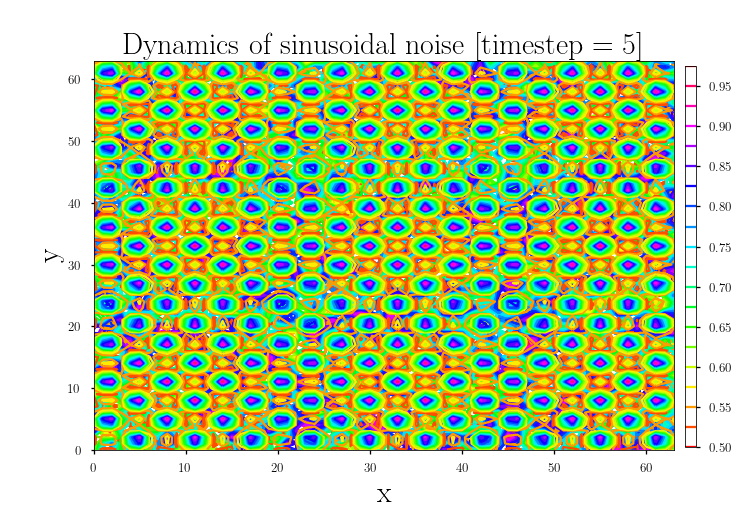

In [136]:
def update_contour_plot_sin(t):
    im = ax.contour(np.abs(sinus_noise_evol[t])**2, 20, cmap = "hsv")
    fig.delaxes(plt.gca())
    cax = fig.add_axes([0.915, 0.13, 0.015, 0.74])
    fig.colorbar(im, cax = cax, ax = ax)
    ax.set_title(r"Dynamics of sinusoidal noise [timestep $= {}$]".format(str(round(t,2))), size = 30)
    return im,

fig = plt.figure()
im = plt.contour(np.abs(init2D_sin)**2, 20, cmap = 'hsv')
ax = fig.gca()
ax.set_title(r"Dynamics of sinusoidal noise [timestep $= {}$]".format(str(round(0,2))), size = 30)
plt.xlabel('x', size = 30)
plt.ylabel('y', size = 30)
cax = fig.add_axes([0.915, 0.13, 0.015, 0.74])
fig.colorbar(im, cax = cax, ax = ax)

anim = animation.FuncAnimation(fig, update_contour_plot_sin,
                               frames=np.arange(0,tsteps,1), # t-values and steps
                               interval=100, # wait time before displaying new frame in ms
                               blit = True)
plt.show()

## 3) Topological defects: Studying the behaviour of vortices in a 2D gas

In 2D other topological defects, called vortices can be present. The given routine initializes a 2D gas containing vortices (and anti-vortices). Our goal is to visualize and analyze their dynamics for different initial vortex distributions. 

### Tools for the vortex grids 

In [143]:
#Vortex with winding number n = +- 1
def add_2d_vortex_simple(grid, x_pos, y_pos, n, N, g):
    grid_h = grid
    f0 = np.sqrt(1.*N/(grid.shape[0]*grid.shape[1]))
    #print(f0**2)
    xi = 1./(2*f0*np.sqrt(g))
    #print(xi)
    for x2 in np.arange(0,grid.shape[0]):
        for y2 in np.arange(0,grid.shape[1]):
            ### shape of the vortex, rho = 0 at the core, i.e. if x_pos = x2 and y_pos = y2
            rho = x_pos-x2 + 1j*n*(y_pos-y2)
            #### multiply homogeneous background field with shape of vortex
            grid_h[x2,y2] *= (1.0/ xi / np.sqrt(2. + np.abs(rho)**2/xi/xi)) * rho
    return grid_h

#Vortex with winding number n  
def add_2d_vortex_simple_n(grid, x_pos, y_pos, n, N, g):
    grid_h = grid
    f0 = np.sqrt(1.*N/(grid.shape[0]*grid.shape[1]))
    #print(f0**2)
    xi = 1./(2*f0*np.sqrt(g))
    #print xi

    sn = (int) (n/np.sqrt(n*n))
    wn = (int) (np.sqrt(n*n))
    
    for x2 in np.arange(0,grid.shape[0]):
        
        for y2 in np.arange(0,grid.shape[1]):
            
            rho = x_pos-x2 + 1j*sn*(y_pos-y2)
            rho *= (1.0/ xi / np.sqrt(2. + np.abs(rho)**2/xi/xi))
            rho = rho**wn
            
            grid_h[x2,y2] *= rho
        
    return grid_h


def add_2d_vortex(grid, x_pos, y_pos, n, N, g):
    """ 
    add a single vortex to the grid 
    @params:
    grid : numerical real space grid
    x_pos : x-position of vortex
    y_pos : y-9position of vortex
    n : quantization of vortex
    N : total particle number
    g : non-linear coupling
    """
    grid_h = grid
    if((int) (np.sqrt(n*n)) == 1):

        print("Only single quantized vortices")
        
        grid_h = add_2d_vortex_simple(grid_h, x_pos, y_pos, n, N, g)
        
        #Adding "mirror vortices" on all 8 adjacent cells to respect periodic boundaries:
        grid_h = add_2d_vortex_simple(grid_h, x_pos+grid.shape[0], y_pos, n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos+grid.shape[0], y_pos-grid.shape[1], n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos, y_pos-grid.shape[1], n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos-grid.shape[0], y_pos-grid.shape[1], n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos-grid.shape[0], y_pos, n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos-grid.shape[0], y_pos+grid.shape[1], n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos, y_pos+grid.shape[1], n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos+grid.shape[0], y_pos+grid.shape[1], n, N, g)

    else:

        print("Vortices with higher quantization")
        
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos, y_pos, n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos+grid.shape[0], y_pos, n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos+grid.shape[0], y_pos-grid.shape[1], n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos, y_pos-grid.shape[1], n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos-grid.shape[0], y_pos-grid.shape[1], n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos-grid.shape[0], y_pos, n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos-grid.shape[0], y_pos+grid.shape[1], n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos, y_pos+grid.shape[1], n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos+grid.shape[0], y_pos+grid.shape[1], n, N,g)
        
    return grid_h

def create_2d_random_vortexpair_grid(nx_grid,ny_grid,num_vortex_pairs,N,g):
    """
    Function creates a grid with randomly placed singly quantized vortices, equal number of 
    vortices with n=1 and antivortices with n=-1
    @params:
    nx_grid : number of grid points in x-direction
    ny_grid : number of grid points in y-direction
    num_vortex_pairs : number of vortex pairs with quantization n= +-1 on the grid
    N : total particle number
    g : non-linear coupling
    """
    
    grid = create_condensed_grid(nx_grid, ny_grid,N)

    for i in np.arange(0,num_vortex_pairs):

        grid = add_2d_vortex(grid, nx_grid*np.random.random(), ny_grid*np.random.random(), 1, N ,g)
        grid = add_2d_vortex(grid, nx_grid*np.random.random(), ny_grid*np.random.random(), -1, N ,g)

    return grid


def create_2d_random_vortex_grid(nx_grid,ny_grid,num_vortices,n,N,g):
    """
    function creates a grid with randomly placed n-quantized vortices, equal quantization of all vortices 
    """
    grid = create_condensed_grid(nx_grid, ny_grid,N)

    for i in np.arange(0,num_vortices):

        grid = add_2d_vortex(grid, nx_grid*np.random.random(), ny_grid*np.random.random(), n, N ,g)

    return grid

def create_2d_regular_vortex_grid(nx_grid,ny_grid,lx,ly,n,N,g):
    """
    Function creates a grid with a regular vortex configuration, vortices can also be highly quantized 
    (n>1 or n<-1), arrangement in a checkerboard manner, i.e. vortices would correspond
    for example to black fields and antivortices to white fields of a checkerboard
    @params:
    nx_grid : number of grid points in x-direction
    ny_grid : number of grid points in y-direction
    lx : number of defects in x-direction of checkerboard
    ly : number of defects in y-direction of checkerboard
    n : quantization of the vortices
    N : total particle number
    g : non-linear coupling
    """
    
    grid = create_condensed_grid(nx_grid, ny_grid,N)

    dist_x = 1.*nx_grid/lx
    dist_y = 1.*ny_grid/ly

    print(dist_x)
    
    sy = 1
    for x in np.arange(1,lx+1):

        sx = 1
        for y in np.arange(1,ly+1):

            grid = add_2d_vortex(grid, dist_x*x, dist_y*y, sy*sx*n, N,g)
            sx *= -1

        sy*= -1

    return grid

### Initializing the vortex grids

In [183]:
def main(do_random_vortexpair_grid = True, do_random_vortex_grid = False, do_regular_vortex_grid = False):
    """
    Main program to initialize a vortex grid
    """
    #do_random_vortexpair_grid = False     ### if True initial grid will be vortex grid with an equal number
        #of vortices and antivortices placed at random positions
    #do_random_vortex_grid = True       ### if True initial grid will be vortex grid composed of vortices 
        #with equal quantization placed at random positions
    #do_regular_vortex_grid = False        ### if True initial grid will be regular vortex grid,
        #i.e. equal distances between vortices and antivortices
    
    nx_grid = 64    ### number of grid points in x-direction
    ny_grid = 64    ### number of grid points in y-direction

    xi = 4          ### healing length, resolved with 4 grid points, if you use a small grid you can go down
                        #to 2 grid points
    g = 1e-2        ### non-linear GPE coupling
    rho = 1./(2*g*xi**2)    ### homogeneous background density
    print("Homogeneous background density:" , rho)
    
    N = rho * nx_grid * ny_grid   ### total particle number of simulation
    print("Particle number: " , N)

    if(do_random_vortexpair_grid):
        num_vortex_pairs = 6     ### number of vortex pairs with quantization n = +-1 
        grid = create_2d_random_vortexpair_grid(nx_grid,ny_grid, num_vortex_pairs, N,g)

    if(do_random_vortex_grid):
        num_vortices = 10     ### total number of vortices
        n = 2                 ### quantization of vortices
        grid = create_2d_random_vortex_grid(nx_grid,ny_grid, num_vortices,n, N,g)

    if(do_regular_vortex_grid):
        lx = 2     ### number of vortices in x-direction on checkerboard
        ly = 2     ### number of vortices in y-direction on checkerboard
        n = 4      ### quantization of the vortices 
        grid = create_2d_regular_vortex_grid(nx_grid, ny_grid, lx, ly, n, N, g)
        
    grid *= np.sqrt(1.*N/calculate_particle_number(grid))    ### normalize to initially set particle number
    print("Particle number on created vortex grid: ", calculate_particle_number(grid))
    
    
    dt = 0.05
    tsteps = 100
    
    dx = 1
    kx_ = 2*np.pi * np.fft.fftfreq(nx_grid, d = dx)
    ky_ = 2*np.pi * np.fft.fftfreq(ny_grid, d = dx)
    kx, ky = np.meshgrid(kx_, ky_)

    kinetic_evolution = np.exp(-1j  * (kx**2 + ky**2) * dt / 2)    
    
    time_evol = full_split_step_method(grid, kinetic_evolution, g = 10, dt = dt, tsteps = tsteps)
        
    return time_evol

### Vortex-Antivortex pairs (n = 1) with the same charge

Homogeneous background density: 3.125
Particle number:  12800.0
Only single quantized vortices
Only single quantized vortices
Only single quantized vortices
Only single quantized vortices
Only single quantized vortices
Only single quantized vortices
Only single quantized vortices
Only single quantized vortices
Only single quantized vortices
Only single quantized vortices
Only single quantized vortices
Only single quantized vortices
Particle number on created vortex grid:  12800.0


<IPython.core.display.Javascript object>


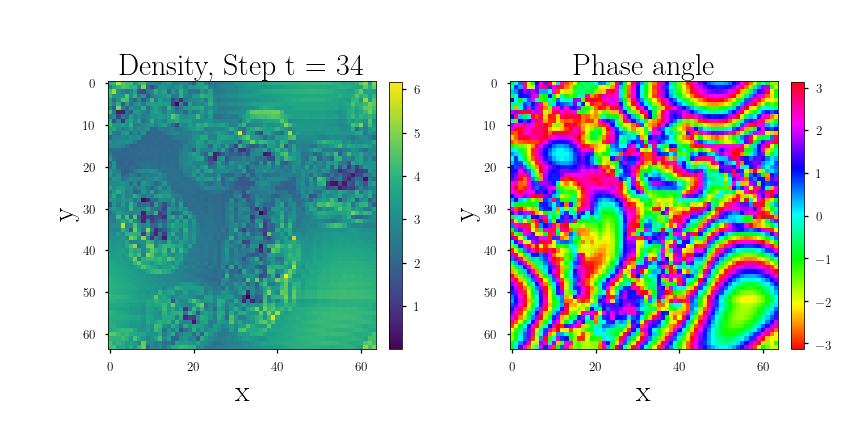

In [193]:
time_evol = main(True, False, False)

myfig, myaxes = plt.subplots(1, 2, figsize = (12, 6))
plt.gcf().subplots_adjust(wspace = 0.5)
myaxes[0].set_title(r'Density, Step t = {}'.format(0), size = 30)
myaxes[0].set_xlabel('x', size = 30)
myaxes[0].set_ylabel('y', size = 30)
myim0 = myaxes[0].imshow(np.abs(time_evol[0])**2)
mycax0 = myfig.add_axes([0.45, 0.191, 0.015, 0.62])
myfig.colorbar(myim0, cax = mycax0, ax = myaxes[0])

myaxes[1].set_title('Phase angle', size = 30)
myaxes[1].set_xlabel('x', size = 30)
myaxes[1].set_ylabel('y', size = 30)
myim1 = myaxes[1].imshow(np.angle(time_evol[0]), cmap = 'hsv')
mycax1 = myfig.add_axes([0.915, 0.191, 0.015, 0.62])
myfig.colorbar(myim1, cax = mycax1, ax = myaxes[1])

def update_image(t):
    global time_evol
    myaxes[0].set_title(r'Density, Step t = {}'.format(t), size = 30)
    
    myim0 = myaxes[0].imshow(np.abs(time_evol[t])**2)
    myfig.delaxes(plt.gca())

    myim1 = myaxes[1].imshow(np.angle(time_evol[t]), cmap = 'hsv')
    myfig.delaxes(plt.gca())

    mycax0 = myfig.add_axes([0.45, 0.191, 0.015, 0.62])
    myfig.colorbar(myim0, cax = mycax0, ax = myaxes[0])

    mycax1 = myfig.add_axes([0.915, 0.191, 0.015, 0.62])
    myfig.colorbar(myim1, cax = mycax1, ax = myaxes[1])
    
ani = animation.FuncAnimation(myfig, update_image,
                                   frames=np.arange(0, tsteps, 1), # t-values and steps
                                   interval=100, # wait time before displaying new frame in ms
                                   blit = True)

### Randomly placed vortices with higher charges

Homogeneous background density: 3.125
Particle number:  12800.0
Vortices with higher quantization
Vortices with higher quantization
Vortices with higher quantization
Vortices with higher quantization
Vortices with higher quantization
Vortices with higher quantization
Vortices with higher quantization
Vortices with higher quantization
Vortices with higher quantization
Vortices with higher quantization
Particle number on created vortex grid:  12800.0


<IPython.core.display.Javascript object>


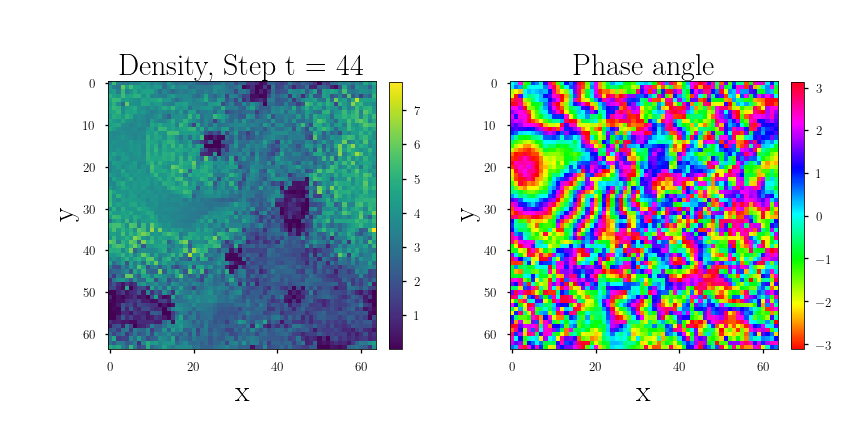

In [194]:
time_evol = main(False, True, False)

myfig, myaxes = plt.subplots(1, 2, figsize = (12, 6))
plt.gcf().subplots_adjust(wspace = 0.5)
myaxes[0].set_title(r'Density, Step t = {}'.format(0), size = 30)
myaxes[0].set_xlabel('x', size = 30)
myaxes[0].set_ylabel('y', size = 30)
myim0 = myaxes[0].imshow(np.abs(time_evol[0])**2)
mycax0 = myfig.add_axes([0.45, 0.191, 0.015, 0.62])
myfig.colorbar(myim0, cax = mycax0, ax = myaxes[0])

myaxes[1].set_title('Phase angle', size = 30)
myaxes[1].set_xlabel('x', size = 30)
myaxes[1].set_ylabel('y', size = 30)
myim1 = myaxes[1].imshow(np.angle(time_evol[0]), cmap = 'hsv')
mycax1 = myfig.add_axes([0.915, 0.191, 0.015, 0.62])
myfig.colorbar(myim1, cax = mycax1, ax = myaxes[1])

def update_image(t):
    global time_evol
    myaxes[0].set_title(r'Density, Step t = {}'.format(t), size = 30)
    
    myim0 = myaxes[0].imshow(np.abs(time_evol[t])**2)
    myfig.delaxes(plt.gca())

    myim1 = myaxes[1].imshow(np.angle(time_evol[t]), cmap = 'hsv')
    myfig.delaxes(plt.gca())

    mycax0 = myfig.add_axes([0.45, 0.191, 0.015, 0.62])
    myfig.colorbar(myim0, cax = mycax0, ax = myaxes[0])

    mycax1 = myfig.add_axes([0.915, 0.191, 0.015, 0.62])
    myfig.colorbar(myim1, cax = mycax1, ax = myaxes[1])
    
ani = animation.FuncAnimation(myfig, update_image,
                                   frames=np.arange(0, tsteps, 1), # t-values and steps
                                   interval=100, # wait time before displaying new frame in ms
                                   blit = True)

### Equidistant placement of vortices with higher charges

Homogeneous background density: 3.125
Particle number:  12800.0
32.0
Vortices with higher quantization
Vortices with higher quantization
Vortices with higher quantization
Vortices with higher quantization
Particle number on created vortex grid:  12800.0


<IPython.core.display.Javascript object>


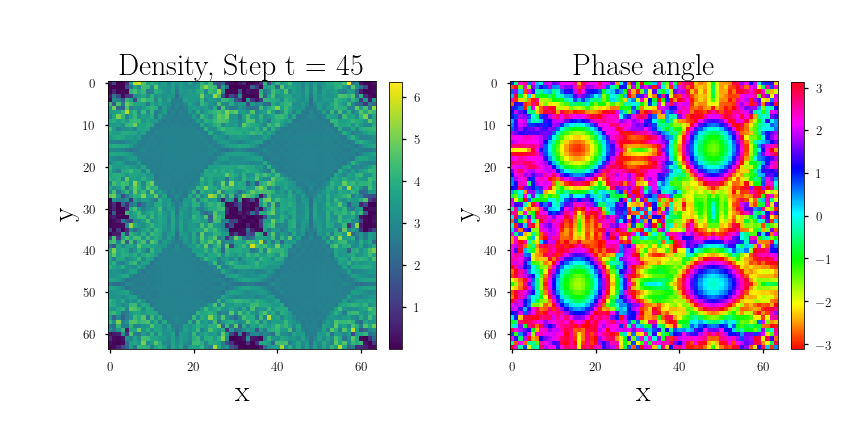

In [195]:
time_evol = main(False, False, True)

myfig, myaxes = plt.subplots(1, 2, figsize = (12, 6))
plt.gcf().subplots_adjust(wspace = 0.5)
myaxes[0].set_title(r'Density, Step t = {}'.format(0), size = 30)
myaxes[0].set_xlabel('x', size = 30)
myaxes[0].set_ylabel('y', size = 30)
myim0 = myaxes[0].imshow(np.abs(time_evol[0])**2)
mycax0 = myfig.add_axes([0.45, 0.191, 0.015, 0.62])
myfig.colorbar(myim0, cax = mycax0, ax = myaxes[0])

myaxes[1].set_title('Phase angle', size = 30)
myaxes[1].set_xlabel('x', size = 30)
myaxes[1].set_ylabel('y', size = 30)
myim1 = myaxes[1].imshow(np.angle(time_evol[0]), cmap = 'hsv')
mycax1 = myfig.add_axes([0.915, 0.191, 0.015, 0.62])
myfig.colorbar(myim1, cax = mycax1, ax = myaxes[1])

def update_image(t):
    global time_evol
    myaxes[0].set_title(r'Density, Step t = {}'.format(t), size = 30)
    
    myim0 = myaxes[0].imshow(np.abs(time_evol[t])**2)
    myfig.delaxes(plt.gca())

    myim1 = myaxes[1].imshow(np.angle(time_evol[t]), cmap = 'hsv')
    myfig.delaxes(plt.gca())

    mycax0 = myfig.add_axes([0.45, 0.191, 0.015, 0.62])
    myfig.colorbar(myim0, cax = mycax0, ax = myaxes[0])

    mycax1 = myfig.add_axes([0.915, 0.191, 0.015, 0.62])
    myfig.colorbar(myim1, cax = mycax1, ax = myaxes[1])
    
ani = animation.FuncAnimation(myfig, update_image,
                                   frames=np.arange(0, tsteps, 1), # t-values and steps
                                   interval=100, # wait time before displaying new frame in ms
                                   blit = True)